In [179]:
import numpy as np
import torch.nn as nn
import torch
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from itertools import product

In [180]:
# Load the MB Model

class CustomModel_CF(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Sequential(
            nn.Linear(5,8),
            nn.ReLU(),
            nn.Linear(8,4),
            nn.ReLU(),
            nn.Linear(4,2),
            nn.ReLU(),
            nn.Linear(2,1),
        )

    def forward(self, x):
        t = x[:,4].unsqueeze(1)
        C0 = x[:,3].unsqueeze(1)
        a0 = self.hidden(x).chunk(5, dim=1)

        k = a0[0]**2


        return C0*torch.exp(-k*t)

class CustomModel_CA(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Sequential(
            nn.Linear(5,10),
            nn.ReLU(),
            nn.Linear(10,5),
            nn.ReLU(),
            nn.Linear(5,1)
        )

    def forward(self, x):
        t = x[:,4].unsqueeze(1)
        C0 = x[:,3].unsqueeze(1)
        a0= self.hidden(x).chunk(5, dim=1)

        k = a0[0]**2


        return C0*(1-torch.exp(-k*t))
    
model_CF = CustomModel_CF()
model_CF.load_state_dict(torch.load('model_CF.pth'))
model_CA = CustomModel_CA()
model_CA.load_state_dict(torch.load('model_CA.pth'))

<All keys matched successfully>

In [181]:
# Load the surrogate model
with open('GPR1.pkl', 'rb') as f:
    GPR1 = pickle.load(f)

with open('GPR2.pkl', 'rb') as f:
    GPR2 = pickle.load(f)

In [182]:
# Load the Data
raw_Data= pd.read_excel('BMED_data.xlsx',sheet_name="Opt")
display(raw_Data[:5])

,T,V,E,Ci,t,CF,CA,SEC,JLA
0,35,35,0.5,3.247751,2.000000,2.666598,0.278508,6.563329,223.608106
1,35,35,0.5,3.247751,2.933333,2.470914,0.583058,5.408487,543.993190
2,35,35,0.5,3.247751,3.933333,2.193242,1.068941,3.958080,1056.942907
3,35,35,0.5,3.247751,4.933333,1.570518,1.598939,3.211235,1337.426543
4,35,35,0.5,3.247751,5.933333,0.258292,2.087098,2.788854,1432.411229


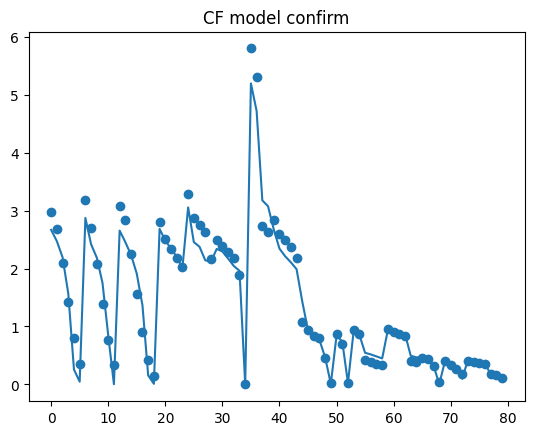

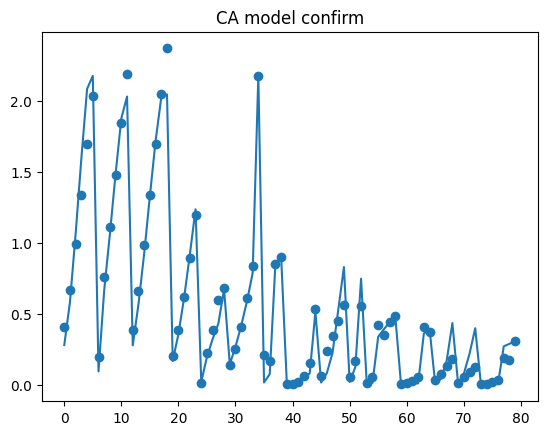

In [183]:
# MB model confirmation
df_MB_columns = ['T','V','E','Ci','t','CF','CA']
df_MB = raw_Data[df_MB_columns]

# Data Set
Xm = df_MB[['T','V','E','Ci','t']].values
Xt = torch.FloatTensor(Xm)

CF_p = model_CF(Xt).detach().numpy()
CA_p = model_CA(Xt).detach().numpy()
CF = df_MB[['CF']].values
CA = df_MB[['CA']].values

plt.plot(list(range(len(Xm))),CF)
plt.scatter(list(range(len(Xm))),CF_p)
plt.title('CF model confirm')
plt.show()

plt.plot(list(range(len(Xm))),CA)
plt.scatter(list(range(len(Xm))),CA_p)
plt.title('CA model confirm')
plt.show()

In [184]:
# GP model confirmation
df_GP_columns = ['T','V','E','Ci','t','CF','CA','SEC','JLA']
df_GP = raw_Data[df_GP_columns]

# Data Set
Xg = df_GP[['Ci','CF','CA']].values
Yg = df_GP[['SEC','JLA']].values

Ci, CF, CA = [i[0] for i in Xg], [i[1] for i in Xg], [i[2] for i in Xg]
SEC, JLA = [i[0] for i in Yg], [i[1] for i in Yg]

# min-max normalization
mXg = list(range(len(Xg)))
mYg = list(range(len(Yg)))

for i in range(len(mXg)):
    iX = [(Ci[i]-np.min(Ci))/(np.max(Ci)-np.min(Ci)),(CF[i]-np.min(CF))/(np.max(CF)-np.min(CF)),(CA[i]-np.min(CA))/(np.max(CA)-np.min(CA))]
    iY = [(SEC[i]-np.min(SEC))/(np.max(SEC)-np.min(SEC)),(JLA[i]-np.min(JLA))/(np.max(JLA)-np.min(JLA))]
    mXg[i], mYg[i] = iX, iY
mX, mY = np.asarray(mXg), np.log(np.asarray(mYg)+1e-10)

In [185]:
dSEC_log, dJLA_log = GPR1.predict(mX), GPR2.predict(mX)

mSEC = np.exp(dSEC_log)-1e-10
mJLA = np.exp(dJLA_log)-1e-10

SECp = list(range(len(Xg)))
JLAp = list(range(len(Xg)))
for i in range(len(Xg)):
    iSEC = (np.max(SEC) - np.min(SEC))*mSEC[i] + np.min(SEC)
    iJLA = (np.max(JLA) - np.min(JLA))*mJLA[i] + np.min(JLA)
    SECp[i] = iSEC
    JLAp[i] = iJLA



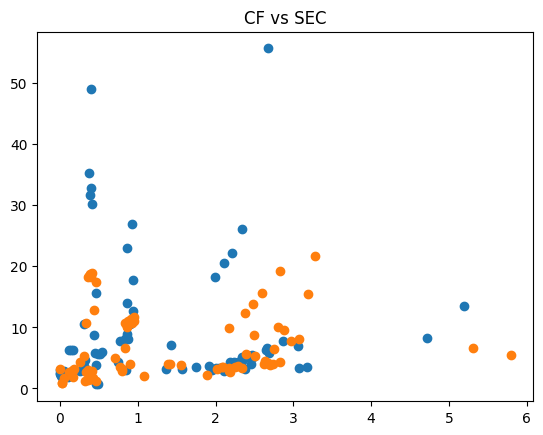

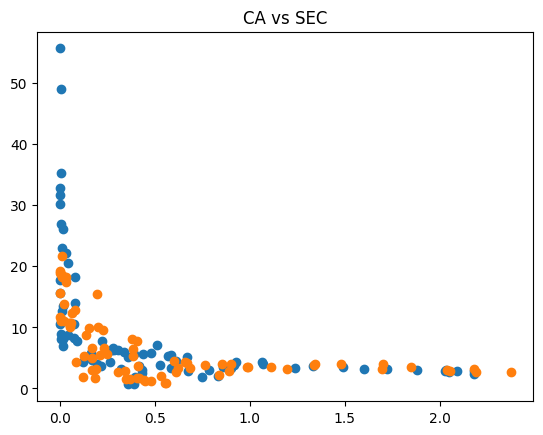

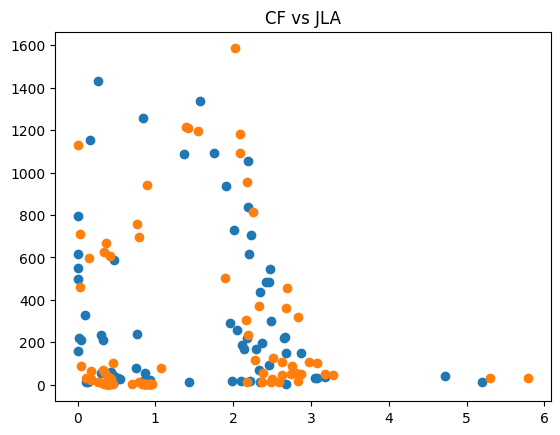

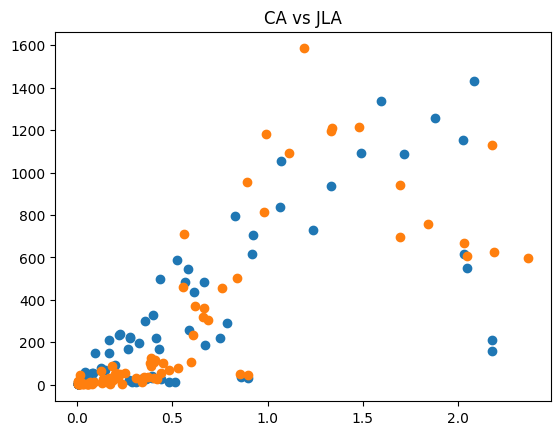

In [186]:
plt.scatter(raw_Data['CF'],raw_Data['SEC'])
plt.scatter(CF_p,SECp)
plt.title('CF vs SEC')
plt.show()
plt.scatter(raw_Data['CA'],raw_Data['SEC'])
plt.scatter(CA_p,SECp)
plt.title('CA vs SEC')
plt.show()
plt.scatter(raw_Data['CF'],raw_Data['JLA'])
plt.scatter(CF_p,JLAp)
plt.title('CF vs JLA')
plt.show()
plt.scatter(raw_Data['CA'],raw_Data['JLA'])
plt.scatter(CA_p,JLAp)
plt.title('CA vs JLA')
plt.show()

In [227]:
# nT = np.unique(raw_Data['T'].values)
# nV = np.unique(raw_Data['V'].values)
# nE = np.unique(raw_Data['E'].values)
# nC = np.unique(raw_Data['Ci'].values)
# nt = np.unique(raw_Data['t'].values)
nT = np.linspace(25,36,5)
nV = np.linspace(10,36,5)
nE = np.linspace(0.25,1.25,5)
nC = np.linspace(0.4,6.5,10)
nt = np.linspace(1,30,30)
print('nC done')
input = np.array(list(product(nT,nV,nE,nC,nt)))
print('input done')
# Xm = df_MB[['T','V','E','Ci','t']].values
# input = np.array(Xm)
in_t = torch.FloatTensor(input)
print('in_t Done')
CFp = model_CF(in_t).detach().numpy()
print('CFP done')
CAp = model_CA(in_t).detach().numpy()
print('CAP done')

Cip = [i[3] for i in input]

# min-max normalization
mXg = list(range(len(input)))

for i in range(len(mXg)):
    iX = [(Cip[i]-np.min(Ci))/(np.max(Ci)-np.min(Ci)),(CFp[i][0]-np.min(CF))/(np.max(CF)-np.min(CF)),(CAp[i][0]-np.min(CA))/(np.max(CA)-np.min(CA))]
    mXg[i] = iX
    if i%100 ==0:
        print(f'Iteration: {i}/{len(input)}')
mX = np.asarray(mXg)

nC done
input done
in_t Done
CFP done
CAP done
Iteration: 0/37500
Iteration: 100/37500
Iteration: 200/37500
Iteration: 300/37500
Iteration: 400/37500
Iteration: 500/37500
Iteration: 600/37500
Iteration: 700/37500
Iteration: 800/37500
Iteration: 900/37500
Iteration: 1000/37500
Iteration: 1100/37500
Iteration: 1200/37500
Iteration: 1300/37500
Iteration: 1400/37500
Iteration: 1500/37500
Iteration: 1600/37500
Iteration: 1700/37500
Iteration: 1800/37500
Iteration: 1900/37500
Iteration: 2000/37500
Iteration: 2100/37500
Iteration: 2200/37500
Iteration: 2300/37500
Iteration: 2400/37500
Iteration: 2500/37500
Iteration: 2600/37500
Iteration: 2700/37500
Iteration: 2800/37500
Iteration: 2900/37500
Iteration: 3000/37500
Iteration: 3100/37500
Iteration: 3200/37500
Iteration: 3300/37500
Iteration: 3400/37500
Iteration: 3500/37500
Iteration: 3600/37500
Iteration: 3700/37500
Iteration: 3800/37500
Iteration: 3900/37500
Iteration: 4000/37500
Iteration: 4100/37500
Iteration: 4200/37500
Iteration: 4300/375

In [228]:
dSEC_log = GPR1.predict(mX)
dJLA_log = GPR2.predict(mX)

mSEC = np.exp(dSEC_log)-1e-10
mJLA = np.exp(dJLA_log)-1e-10



SECp = list(range(len(mSEC)))
JLAp = list(range(len(mSEC)))
for i in range(len(mSEC)):
    iSEC = (np.max(SEC) - np.min(SEC))*mSEC[i] + np.min(SEC)
    iJLA = (np.max(JLA) - np.min(JLA))*mJLA[i] + np.min(JLA)
    SECp[i] = iSEC
    JLAp[i] = iJLA

In [222]:
columns = ['T','V','E','Ci','t']
df = pd.DataFrame(input, columns= columns)
df['CF'] = CFp
df['CA'] = CAp
df['SECp'] = SECp
df['JLAp'] = JLAp
display(df)

df.to_excel('CFCA.xlsx', index = False)

,T,V,E,Ci,t,CF,CA,SECp,JLAp
0,25.0,10.0,0.25,0.418555,1.000000,0.400511,0.001619,18.996720,2.858120
1,25.0,10.0,0.25,0.418555,1.783333,0.386922,0.004898,18.477947,2.929859
2,25.0,10.0,0.25,0.418555,2.000000,0.383245,0.006216,18.276200,2.957629
3,25.0,10.0,0.25,0.418555,2.783333,0.370242,0.012762,17.317333,3.095502
4,25.0,10.0,0.25,0.418555,2.933333,0.367803,0.014364,17.092441,3.129795
...,...,...,...,...,...,...,...,...,...
10795,35.0,35.0,1.00,6.328111,22.500000,0.000016,0.892268,3.298018,10.368685
10796,35.0,35.0,1.00,6.328111,23.000000,0.000012,0.733339,3.931640,8.484358
10797,35.0,35.0,1.00,6.328111,23.466667,0.000009,0.593296,4.808299,6.873396
10798,35.0,35.0,1.00,6.328111,24.000000,0.000006,0.445625,6.311290,5.342148


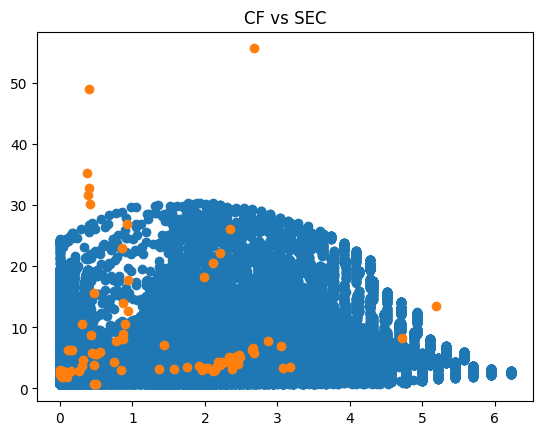

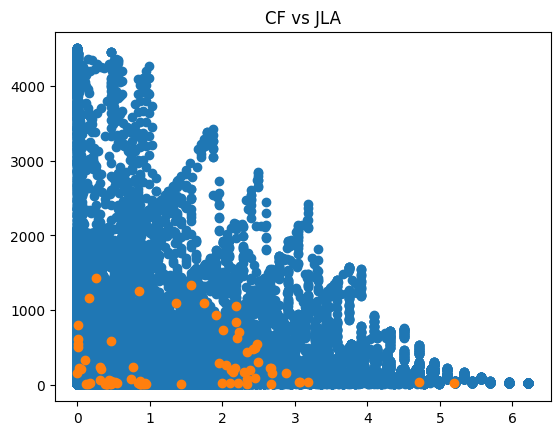

In [229]:
plt.scatter(CFp,SECp)
plt.scatter(raw_Data['CF'],raw_Data['SEC'])
plt.title('CF vs SEC')
plt.show()
plt.scatter(CFp,JLAp)
plt.scatter(raw_Data['CF'],raw_Data['JLA'])
plt.title('CF vs JLA')
plt.show()



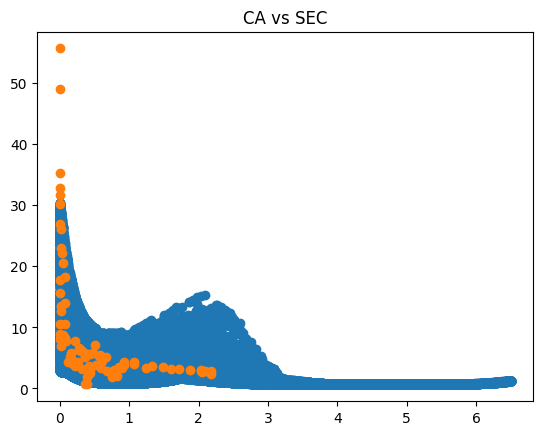

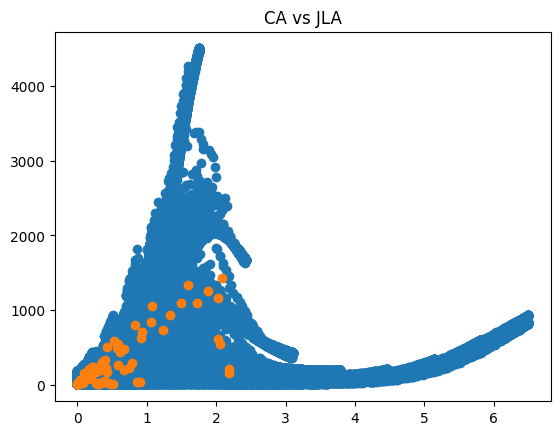

In [230]:
plt.scatter(CAp,SECp)
plt.scatter(raw_Data['CA'],raw_Data['SEC'])
plt.title('CA vs SEC')
plt.show()
plt.scatter(CAp,JLAp)
plt.scatter(raw_Data['CA'],raw_Data['JLA'])
plt.title('CA vs JLA')
plt.show()